In [1]:
# ## install finrl library
# !pip install wrds
# !pip install swig
# !pip install yfinance==0.2.44
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/flpymonkey/FinRL-Fork.git

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [5]:
# TODO, remove DOW from training as it is missing some values in 2019
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

TIME_WINDOW = 40
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO currently an issue with yfiance
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

# df_list = []

# for ticker in DOW_30_TICKER:
#     # Fetch data for each ticker
#     portfolio_raw_df = YahooDownloader(start_date=TRAIN_START_DATE,
#                                        end_date=TEST_END_DATE,
#                                        ticker_list=[ticker]).fetch_data()
#     # Append the fetched DataFrame to the list
#     df_list.append(portfolio_raw_df)

# # Concatenate all DataFrames row-wise
# portfolio_raw_df = pd.concat(df_list, axis=0, ignore_index=True)
# df = portfolio_raw_df
# # Display the concatenated DataFrame
# print(portfolio_raw_df)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (107677, 8)


In [7]:
import pandas as pd
import yfinance as yf

data_df = pd.DataFrame()
num_failures = 0
for tic in DOW_30_TICKER:
      temp_df = yf.download(
          tic, start=TRAIN_START_DATE, end=TEST_END_DATE, proxy=None
      )
      temp_df["tic"] = tic
      print(temp_df)
      if len(temp_df) > 0:
          # data_df = data_df.append(temp_df)
          data_df = pd.concat([data_df, temp_df], axis=0)
      else:
          num_failures += 1
if num_failures == len(DOW_30_TICKER):
    raise ValueError("no data is fetched.")
  # reset the index, we want to use numbers as index instead of dates
data_df = data_df.reset_index()

data_df

[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   13.340000   14.640000   13.080000   14.440000   11.463928   
2009-04-02   15.260000   15.300000   14.590000   14.980000   11.892635   
2009-04-03   14.800000   15.330000   14.520000   15.330000   12.170503   
2009-04-06   15.080000   15.270000   14.650000   15.160000   12.035537   
2009-04-07   15.120000   15.380000   14.850000   15.010000   11.916456   
...                ...         ...         ...         ...         ...   
2023-12-22  185.639999  186.369995  184.630005  185.570007  183.374313   
2023-12-26  185.960007  186.179993  185.130005  185.960007  183.759705   
2023-12-27  186.139999  187.130005  185.619995  187.059998  184.846664   
2023-12-28  187.119995  188.070007  187.000000  187.800003  185.577927   
2023-12-29  187.750000  188.300003  186.529999  187.339996  185.123352   

              Volume  tic  
Date     


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   48.779999   48.930000   47.099998   48.330002   34.259624   
2009-04-02   49.139999   49.259998   46.599998   47.290001   33.522400   
2009-04-03   47.869999   47.970001   46.080002   46.570000   33.012012   
2009-04-06   46.459999   48.060001   46.369999   47.840000   33.912273   
2009-04-07   47.480000   47.939999   46.889999   47.380001   33.586189   
...                ...         ...         ...         ...         ...   
2023-12-22  280.000000  285.679993  280.000000  284.160004  278.031433   
2023-12-26  284.119995  284.720001  281.670013  283.899994  277.777039   
2023-12-27  284.500000  287.290009  283.350006  286.529999  280.350342   
2023-12-28  287.880005  289.040009  287.630005  288.459991  282.238708   
2023-12-29  287.859985  288.489990  286.390015  288.019989  281.808167   

              Volume   tic  
Date    

[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   34.520000   35.599998   34.209999   35.439999   26.850740   
2009-04-02   36.160000   37.980000   36.160000   37.200001   28.184191   
2009-04-03   37.230000   38.119999   36.389999   37.689999   28.555435   
2009-04-06   37.480000   38.220001   36.540001   38.160000   28.911526   
2009-04-07   37.509998   37.689999   36.509998   36.639999   27.759916   
...                ...         ...         ...         ...         ...   
2023-12-22  261.829987  262.839996  259.200012  260.440002  260.440002   
2023-12-26  259.799988  263.760010  259.540009  262.790009  262.790009   
2023-12-27  262.630005  264.660004  260.899994  262.100006  262.100006   
2023-12-28  261.529999  262.100006  257.679993  260.350006  260.350006   
2023-12-29  260.670013  262.220001  259.559998  260.660004  260.660004   

             Volume tic  
Date       


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   27.500000   29.520000   27.440001   28.990000   19.116177   
2009-04-02   30.290001   31.980000   30.000000   31.540001   20.797663   
2009-04-03   31.600000   32.700001   30.920000   32.150002   21.199898   
2009-04-06   31.719999   32.000000   30.230000   31.309999   20.645996   
2009-04-07   30.389999   30.500000   29.379999   29.450001   19.419500   
...                ...         ...         ...         ...         ...   
2023-12-22  290.309998  292.829987  288.910004  290.359985  285.776489   
2023-12-26  291.589996  297.089996  291.000000  295.630005  290.963318   
2023-12-27  295.630005  299.149994  294.730011  298.119995  293.413971   
2023-12-28  297.100006  299.200012  296.040009  296.880005  292.193573   
2023-12-29  296.850006  298.239990  293.200012  295.670013  291.002655   

              Volume  tic  
Date     


[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   66.000000   68.699997   65.830002   68.300003   36.987495   
2009-04-02   70.000000   71.290001   69.510002   70.309998   38.076008   
2009-04-03   69.900002   70.919998   69.419998   70.480003   38.168068   
2009-04-06   69.739998   70.050003   68.669998   69.889999   37.848549   
2009-04-07   69.059998   69.169998   67.919998   68.400002   37.041656   
...                ...         ...         ...         ...         ...   
2023-12-22  151.740005  152.389999  150.750000  151.050003  146.288574   
2023-12-26  152.070007  153.009995  151.899994  152.410004  147.605713   
2023-12-27  152.270004  152.970001  151.339996  151.910004  147.121475   
2023-12-28  151.179993  152.020004  149.399994  149.770004  145.048935   
2023-12-29  150.029999  150.229996  148.669998  149.160004  144.458145   

              Volume  tic  
Date     


[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01  104.099998  111.339996  103.940002  110.290001   84.783409   
2009-04-02  115.209999  115.900002  112.500000  114.220001   87.804512   
2009-04-03  112.800003  119.760002  112.550003  119.400002   91.786545   
2009-04-06  116.000000  117.949997  114.050003  116.650002   89.672546   
2009-04-07  114.000000  119.760002  113.570000  116.080002   89.234360   
...                ...         ...         ...         ...         ...   
2023-12-22  382.000000  383.489990  379.410004  380.649994  373.488312   
2023-12-26  380.649994  382.609985  380.049988  381.609985  374.430267   
2023-12-27  381.200012  385.750000  380.309998  384.480011  377.246277   
2023-12-28  384.519989  387.760010  383.630005  386.410004  379.139954   
2023-12-29  385.570007  386.640015  383.570007  385.769989  378.512024   

              Volume tic  
Date      


[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   26.446470   27.190100   26.160460   26.989891   19.051476   
2009-04-02   27.847923   29.773729   27.666784   29.144506   20.572365   
2009-04-03   29.106373   29.535389   28.419947   28.791759   20.323376   
2009-04-06   28.648754   28.791759   27.466576   28.400879   20.047461   
2009-04-07   28.124401   28.601086   27.542847   27.924192   19.710981   
...                ...         ...         ...         ...         ...   
2023-12-22  205.050003  207.160004  204.960007  205.639999  202.331665   
2023-12-26  206.139999  208.550003  205.789993  208.039993  204.693039   
2023-12-27  207.160004  209.660004  207.160004  209.020004  205.657303   
2023-12-28  209.320007  209.970001  208.830002  209.169998  205.804871   
2023-12-29  209.220001  210.169998  208.910004  209.710007  206.336197   

              Volume  tic  
Date     


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   91.902489   93.690247   91.491394   93.317398   54.313766   
2009-04-02   94.789673   97.504784   94.053535   96.386230   56.099945   
2009-04-03   95.344170   98.145317   95.325050   97.724663   56.878960   
2009-04-06   96.462715   97.370934   95.602295   97.093689   56.511711   
2009-04-07   95.764816   96.080307   94.187378   94.407265   54.948128   
...                ...         ...         ...         ...         ...   
2023-12-22  161.100006  162.410004  161.000000  162.139999  156.483139   
2023-12-26  162.229996  163.309998  162.050003  163.210007  157.515808   
2023-12-27  163.139999  163.639999  162.679993  163.460007  157.757095   
2023-12-28  163.960007  163.960007  163.399994  163.750000  158.036972   
2023-12-29  163.750000  164.179993  162.830002  163.550003  157.843948   

              Volume  tic  
Date     


[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   52.299999   53.200001   51.880001   53.040001   33.591171   
2009-04-02   53.290001   54.130001   52.660000   52.970001   33.546837   
2009-04-03   53.000000   53.299999   51.750000   52.150002   33.027512   
2009-04-06   52.029999   52.540001   51.669998   52.200001   33.059181   
2009-04-07   51.889999   52.000000   51.279999   51.360001   32.527191   
...                ...         ...         ...         ...         ...   
2023-12-22  155.250000  156.529999  155.020004  155.460007  151.898438   
2023-12-26  155.000000  156.350006  154.850006  156.139999  152.562851   
2023-12-27  155.500000  156.520004  155.419998  156.350006  152.768051   
2023-12-28  156.000000  157.240005  155.990005  156.580002  152.992767   
2023-12-29  156.509995  156.899994  155.979996  156.740005  153.149109   

              Volume  tic  
Date     


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2009-04-01  21.879999  22.495001  21.750000  22.430000  13.890479  21254800   
2009-04-02  22.650000  22.915001  22.325001  22.670000  14.039104  24926400   
2009-04-03  22.684999  22.879999  22.240000  22.485001  13.924540  17886600   
2009-04-06  22.350000  22.615000  22.270000  22.495001  13.930735  16084000   
2009-04-07  22.420000  22.584999  22.230000  22.309999  13.816173  15666200   
...               ...        ...        ...        ...        ...       ...   
2023-12-22  58.119999  58.459999  58.020000  58.320000  57.020828   9028500   
2023-12-26  58.060001  58.709999  58.060001  58.560001  57.255482   6422500   
2023-12-27  58.639999  58.770000  58.400002  58.709999  57.402138   8560100   
2023-12-28  58.650002  58.869999  58.529999  58.750000  57.441250   8400100   
2023-12-29  58.740002  58.980000  58.630001  58.9300


[*********************100%***********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   54.299999   55.330002   53.869999   55.240002   35.810555   
2009-04-02   55.939999   57.060001   55.630001   56.349998   36.530144   
2009-04-03   56.200001   56.639999   55.560001   56.639999   36.718143   
2009-04-06   56.470001   56.610001   55.599998   55.939999   36.264347   
2009-04-07   55.639999   55.770000   54.599998   55.400002   35.914284   
...                ...         ...         ...         ...         ...   
2023-12-22  290.700012  292.470001  290.500000  291.700012  286.511536   
2023-12-26  291.220001  293.049988  290.890015  292.859985  287.650879   
2023-12-27  292.500000  294.630005  292.459991  294.549988  289.310822   
2023-12-28  294.470001  296.470001  294.000000  295.839996  290.577881   
2023-12-29  295.829987  296.850006  295.309998  296.510010  291.235962   

             Volume  tic  
Date      

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   25.276718   25.982824   24.570610   25.753817   15.164788   
2009-04-02   25.963739   26.335878   25.229008   25.763359   15.170408   
2009-04-03   25.763359   26.059160   24.895039   25.248093   14.866993   
2009-04-06   25.076336   26.278625   25.076336   25.448473   14.984988   
2009-04-07   25.324427   25.353052   24.818703   25.066793   14.760242   
...                ...         ...         ...         ...         ...   
2023-12-22  107.150002  108.059998  106.839996  107.699997  105.677666   
2023-12-26  107.500000  108.089996  107.220001  107.629997  105.608986   
2023-12-27  107.309998  108.070000  107.010002  107.980003  105.952423   
2023-12-28  108.300003  109.059998  108.129997  108.769997  106.727577   
2023-12-29  108.989998  109.239998  108.790001  109.019997  106.972878   

              Volume  tic  
Date     


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   18.230000   19.360001   18.180000   19.309999   14.330415   
2009-04-02   19.500000   19.889999   19.000000   19.290001   14.315571   
2009-04-03   19.129999   19.150000   18.430000   18.750000   13.914821   
2009-04-06   18.540001   18.760000   18.270000   18.760000   13.922246   
2009-04-07   18.760000   19.139999   18.629999   18.760000   13.922246   
...                ...         ...         ...         ...         ...   
2023-12-22  373.679993  375.179993  372.709991  374.579987  372.543945   
2023-12-26  375.000000  376.940002  373.500000  374.660004  372.623505   
2023-12-27  373.690002  375.059998  372.809998  374.070007  372.036713   
2023-12-28  375.369995  376.459991  374.160004  375.279999  373.240112   
2023-12-29  376.000000  377.160004  373.480011  376.040009  373.996002   

              Volume   tic  
Date    


[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   46.750000   48.480000   46.290001   48.209999   30.360554   
2009-04-02   48.720001   50.290001   48.720001   49.419998   31.122566   
2009-04-03   49.540001   49.750000   48.720001   49.630001   31.254816   
2009-04-06   49.459999   49.970001   48.910000   49.650002   31.267397   
2009-04-07   49.419998   49.419998   48.529999   48.680000   30.656530   
...                ...         ...         ...         ...         ...   
2023-12-22  144.500000  145.630005  144.289993  145.279999  141.751038   
2023-12-26  145.089996  146.169998  144.970001  145.940002  142.395020   
2023-12-27  145.649994  146.309998  145.360001  146.059998  142.512100   
2023-12-28  146.000000  146.009995  145.039993  145.729996  142.190109   
2023-12-29  146.000000  146.960007  145.729996  146.539993  142.980438   

              Volume tic  
Date      


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-04-01   40.369999   42.450001   39.799999   42.139999   29.047987   
2009-04-02   43.209999   43.860001   41.160000   41.970001   28.930807   
2009-04-03   41.549999   42.650002   41.169998   42.610001   29.371977   
2009-04-06   42.009998   42.459999   41.549999   42.139999   29.047987   
2009-04-07   41.380001   42.639999   41.270000   41.419998   28.551680   
...                ...         ...         ...         ...         ...   
2023-12-22  186.080002  187.000000  184.960007  185.800003  183.244324   
2023-12-26  185.270004  187.419998  185.270004  187.089996  184.516586   
2023-12-27  186.119995  188.729996  186.119995  188.619995  186.025528   
2023-12-28  188.470001  189.940002  188.470001  189.330002  186.725784   
2023-12-29  189.339996  190.820007  188.809998  190.490005  187.869812   

              Volume  tic  
Date     

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2009-04-01  28.005365  29.459093  27.977228  29.280895  13.174377  27432137   
2009-04-02  29.740459  30.997231  29.534124  30.443876  13.697639  30753746   
2009-04-03  30.528288  30.865927  30.340710  30.753380  13.836897  17738453   
2009-04-06  30.584560  31.015989  30.406361  30.978474  13.938173  19507639   
2009-04-07  30.321951  30.321951  29.477852  29.749840  13.574415  15480723   
...               ...        ...        ...        ...        ...       ...   
2023-12-22  37.419998  37.779999  37.400002  37.490002  35.147896  13157900   
2023-12-26  37.439999  37.639999  37.310001  37.480000  35.138519  11856600   
2023-12-27  37.330002  37.459999  37.200001  37.310001  34.979145  15267600   
2023-12-28  37.180000  37.720001  37.150002  37.490002  35.147896  14931700   
2023-12-29  37.380001  37.759998  37.320000  37.7000

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2009-04-01  17.126667  17.683332  17.073334  17.606667  12.571259  67957200   
2009-04-02  17.780001  18.190001  17.733334  17.879999  12.766420  65542800   
2009-04-03  17.900000  18.100000  17.650000  17.933332  12.804496  49566900   
2009-04-06  17.803333  17.916668  17.633333  17.809999  12.716437  46532400   
2009-04-07  17.653334  17.673332  17.333332  17.463333  12.468916  42833100   
...               ...        ...        ...        ...        ...       ...   
2023-12-22  51.816666  52.383331  51.720001  52.216667  51.712521  19405500   
2023-12-26  52.216667  52.330002  52.036667  52.136665  51.633293  11679900   
2023-12-27  52.103333  52.650002  52.053333  52.626667  52.118565  19896000   
2023-12-28  52.590000  52.776669  52.500000  52.523335  52.016232  16776000   
2023-12-29  52.509998  52.693333  52.386665  52.5499

,Date,Open,High,Low,Close,Adj Close,Volume,tic
0,2009-04-01,13.340000,14.640000,13.080000,14.440000,11.463928,27701800,AXP
1,2009-04-02,15.260000,15.300000,14.590000,14.980000,11.892635,27296000,AXP
2,2009-04-03,14.800000,15.330000,14.520000,15.330000,12.170503,19195400,AXP
3,2009-04-06,15.080000,15.270000,14.650000,15.160000,12.035537,16065100,AXP
4,2009-04-07,15.120000,15.380000,14.850000,15.010000,11.916456,18546800,AXP
...,...,...,...,...,...,...,...,...
107672,2023-12-22,91.620003,92.239998,90.750000,91.019997,90.602005,9411500,DIS
107673,2023-12-26,90.839996,91.269997,90.599998,90.949997,90.532326,8086900,DIS
107674,2023-12-27,90.910004,90.940002,90.040001,90.379997,89.964943,11123500,DIS
107675,2023-12-28,90.089996,90.980003,89.970001,90.400002,89.984856,8479600,DIS


In [8]:
# Add additional technical indicators
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']


FEATURES = ["close", "high", "low", "volume"].extend(INDICATORS)

In [9]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

# here you can see the engineered features are added to each stock day
print(processed)


Successfully added technical indicators
Successfully added turbulence index
              date        open        high         low       close     volume  \
0       2009-04-01    3.717500    3.892857    3.710357    3.274470  589372000   
1       2009-04-01   48.779999   48.930000   47.099998   34.259624   10850100   
2       2009-04-01   13.340000   14.640000   13.080000   11.463928   27701800   
3       2009-04-01   34.520000   35.599998   34.209999   26.850740    9288800   
4       2009-04-01   27.500000   29.520000   27.440001   19.116177   15308300   
...            ...         ...         ...         ...         ...        ...   
107672  2023-12-29  525.979980  528.239990  523.919983  520.342285    2080100   
107673  2023-12-29  260.570007  261.459991  259.670013  258.375092    4074600   
107674  2023-12-29   37.380001   37.759998   37.320000   35.344772   16205200   
107675  2023-12-29   26.440001   26.629999   25.750000   24.868887   10853300   
107676  2023-12-29   52.509998   

In [10]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [11]:

# Split this on the train and trade test data

train = data_split(processed, TRAIN_START_DATE,TRAIN_END_DATE)
test = data_split(processed, TEST_START_DATE,TEST_END_DATE)
print(len(train))
print(len(test))


print(test)


train.to_csv('train_data.csv')
test.to_csv('test_data.csv')

85840
21837
           date        open        high         low       close     volume  \
0    2021-01-04  133.520004  133.610001  126.760002  126.544235  143301900   
0    2021-01-04  231.250000  231.250000  223.669998  201.544556    3088200   
0    2021-01-04  121.300003  121.800003  116.849998  112.164024    3472100   
0    2021-01-04  210.000000  210.199997  202.490005  202.720001   21225600   
0    2021-01-04  183.000000  185.979996  180.250000  168.131134    4078300   
..          ...         ...         ...         ...         ...        ...   
752  2023-12-29  525.979980  528.239990  523.919983  520.342285    2080100   
752  2023-12-29  260.570007  261.459991  259.670013  258.375092    4074600   
752  2023-12-29   37.380001   37.759998   37.320000   35.344772   16205200   
752  2023-12-29   26.440001   26.629999   25.750000   24.868887   10853300   
752  2023-12-29   52.509998   52.693333   52.386665   52.042637   21948300   

      tic  day      macd     rsi_30      cci_30    

In [12]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

In [13]:
# Train the data

train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following two lines.
train = train.set_index(train.columns[0])
train.index.names = ['']
test = test.set_index(test.columns[0])
test.index.names = ['']

In [14]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [15]:
buy_cost_list = sell_cost_list = [COMMISSION_FEE_PERCENT] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": INITIAL_CASH,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [16]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [17]:
# Train the PPO agent:
# 
#  https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html

agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
    "clip_range": 0.9,
}

# Lower clip_range makes the stocks flatter, very conservative policy

# TODO try playing around with the number of epochs? n_epochs
# TODO try playing around more with the entropy term, make sure agent does enough exploration during training
# TODO try playing around more with the clip papram here


model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128, 'clip_range': 0.9}
Using cpu device
Logging to results/ppo


In [18]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=5_000)

----------------------------------
| time/              |           |
|    fps             | 110       |
|    iterations      | 1         |
|    time_elapsed    | 18        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1.8070349 |
----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 2          |
|    time_elapsed         | 37         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.16077591 |
|    clip_fraction        | 0.0533     |
|    clip_range           | 0.9        |
|    entropy_loss         | -41.1      |
|    explained_variance   | -0.00162   |
|    learning_rate        | 0.00025    |
|    loss                 | 8.2        |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.07      |
|    reward               | 1

In [19]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo")

In [20]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR

trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") 

# Here is how to load the model

In [21]:
e_trade_gym = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

In [22]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) 

print(df_account_value_ppo)

hit end!
           date  account_value
0    2021-01-04   1.000000e+06
1    2021-01-05   9.998922e+05
2    2021-01-06   1.000188e+06
3    2021-01-07   1.000733e+06
4    2021-01-08   1.001233e+06
..          ...            ...
748  2023-12-22   9.809423e+05
749  2023-12-26   9.807346e+05
750  2023-12-27   9.807167e+05
751  2023-12-28   9.808664e+05
752  2023-12-29   9.809157e+05

[753 rows x 2 columns]


In [23]:
# Compare to CRP

e_trade_gym.reset()
agent_crp = DRLAgent(env = e_trade_gym)
model_crp = agent_crp.get_model("crp", None, None)

crp_values, crp_dates = DRLAgent.DRL_prediction(model_crp, e_trade_gym)

{}
hit end!


In [ ]:
# Compare to BAH

e_trade_gym.reset()
agent_bah = DRLAgent(env = e_trade_gym)
model_bah = agent_bah.get_model("crp", None, None)

bah_values, bah_dates = DRLAgent.DRL_prediction(model_bah, e_trade_gym)

In [24]:
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_ppo['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (753, 8)
Annual return          0.076674
Cumulative returns     0.247011
Annual volatility      0.150172
Sharpe ratio           0.567733
Calmar ratio           0.349457
Stability              0.009880
Max drawdown          -0.219408
Omega ratio            1.101200
Sortino ratio          0.809197
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.004253
Daily value at risk   -0.018582
dtype: float64
df_dji:             date           dji
0    2021-01-04  1.000000e+06
1    2021-01-05  1.005549e+06
2    2021-01-06  1.020034e+06
3    2021-01-07  1.027040e+06
4    2021-01-08  1.028920e+06
..          ...           ...
748  2023-12-22  1.236967e+06
749  2023-12-26  1.242240e+06
750  2023-12-27  1.245919e+06
751  2023-12-28  1.247692e+06
752  2023-12-29  1.247011e+06

[753 rows x 2 columns]
df_dji:                       dji
date                    
2021-01-04  1.000000e+06
2021-01-05  1.005549e+06
2021-01-06  1.020034e+06
2021-01-07  

In [ ]:
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
)

df_result_crp = (
    crp_values.set_index(crp_values.columns[0])
)

df_result_bah = (
    bah_values.set_index(bah_values.columns[0])
)

result = pd.DataFrame(
    {
        "ppo": df_result_ppo["account_value"],
        "crp": df_result_crp["account_value"],
        "bah": df_result_bah["account_value"],
        "dji": df_dji["dji"],
    }
)

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

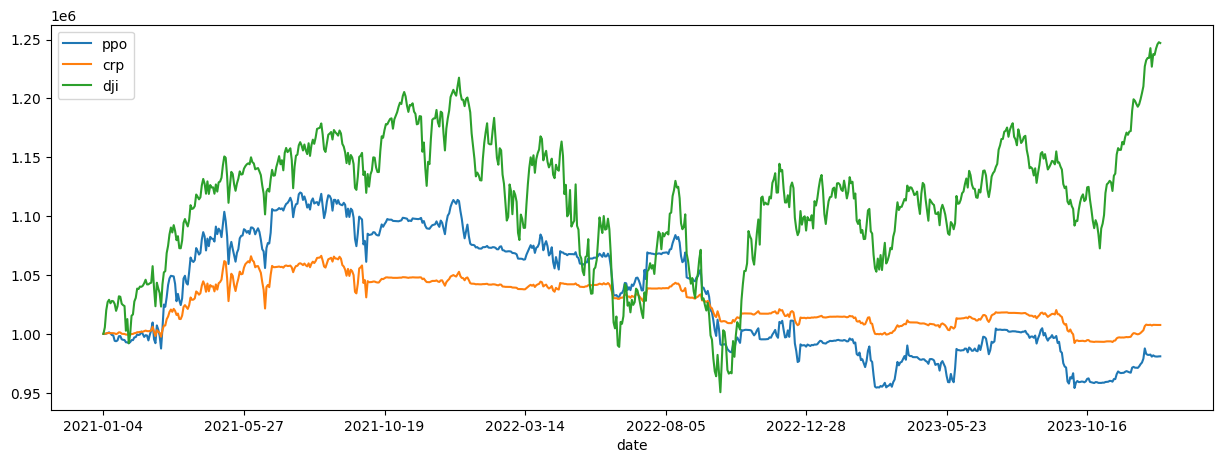

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()